In [19]:
# setup
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
# from sklearn import explain_weights, explain_prediction
# from sklearn import explain_weights_sklearn, explain_prediction_sklearn

# explanability
# import eli5
# from eli5.sklearn import PermutationImportance
import seaborn as sns
import shap

# file
import os

# folder
folder_input = '02_input'


In [20]:
# # import data
# # original data
# org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

# # check any missing value
# org.isnull().sum()


In [21]:
# data import
cleaned_data = pd.read_csv(os.path.join('..', folder_input, 'cleaned_data.csv'))


In [22]:
cleaned_data.info()
cleaned_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Churn                  7043 non-null   bool   
 1   gender                 7043 non-null   object 
 2   SeniorCitizen          7043 non-null   int64  
 3   Partner                7043 non-null   object 
 4   Dependents             7043 non-null   object 
 5   FamilySize             7043 non-null   int64  
 6   PhoneService           7043 non-null   object 
 7   MultipleLines          7043 non-null   object 
 8   InternetService        7043 non-null   object 
 9   OnlineSecurity         7043 non-null   object 
 10  OnlineBackup           7043 non-null   object 
 11  DeviceProtection       7043 non-null   object 
 12  TechSupport            7043 non-null   object 
 13  StreamingTV            7043 non-null   object 
 14  StreamingMovies        7043 non-null   object 
 15  Pape

,Churn,gender,SeniorCitizen,Partner,Dependents,FamilySize,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,tenure,MonthlyChargesPerHead,Is_Contract_Locked
0,False,Female,0,Yes,No,2,No,No phone service,DSL,No,Yes,No,No,No,No,Yes,Electronic check,1,14.925,0
1,True,Female,0,Yes,No,2,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,Electronic check,28,52.400,0
2,False,Male,0,Yes,No,2,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,No,Credit card (automatic),58,50.175,1
3,False,Male,0,Yes,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,Bank transfer (automatic),12,9.900,1
4,False,Female,0,Yes,No,2,Yes,Yes,DSL,No,Yes,No,Yes,No,No,Yes,Credit card (automatic),58,29.950,1


In [23]:
# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
# preprocessing for categorical data
cleaned_data.info()

# select categorical columns
# PS: [categorical_cols] mean == True
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# one hot encoder
# PS: The one hot encoder output is a series, need to turn to dataframe
cat_encoder = OrdinalEncoder()
OH_cols_train = pd.DataFrame(cat_encoder.fit_transform(X_train[categorical_cols]))
OH_cols_test = pd.DataFrame(cat_encoder.fit_transform(X_test[categorical_cols]))


# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# add back colnames
OH_cols_train.columns = cat_encoder.get_feature_names_out()
OH_cols_test.columns = cat_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


X_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Churn                  7043 non-null   bool   
 1   gender                 7043 non-null   object 
 2   SeniorCitizen          7043 non-null   int64  
 3   Partner                7043 non-null   object 
 4   Dependents             7043 non-null   object 
 5   FamilySize             7043 non-null   int64  
 6   PhoneService           7043 non-null   object 
 7   MultipleLines          7043 non-null   object 
 8   InternetService        7043 non-null   object 
 9   OnlineSecurity         7043 non-null   object 
 10  OnlineBackup           7043 non-null   object 
 11  DeviceProtection       7043 non-null   object 
 12  TechSupport            7043 non-null   object 
 13  StreamingTV            7043 non-null   object 
 14  StreamingMovies        7043 non-null   object 
 15  Pape

,SeniorCitizen,FamilySize,tenure,MonthlyChargesPerHead,Is_Contract_Locked,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod
3296,0,1,19,84.750000,0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0
6397,0,3,72,23.816667,1,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0
6043,0,3,61,33.050000,0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,1.0,2.0
5309,0,3,34,8.316667,1,0.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3000,0,1,71,53.950000,1,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0


In [25]:
cleaned_data.dtypes.isin(['int64', 'float64'])


Churn                    False
gender                   False
SeniorCitizen            False
Partner                  False
Dependents               False
FamilySize               False
PhoneService             False
MultipleLines            False
InternetService          False
OnlineSecurity           False
OnlineBackup             False
DeviceProtection         False
TechSupport              False
StreamingTV              False
StreamingMovies          False
PaperlessBilling         False
PaymentMethod            False
tenure                   False
MonthlyChargesPerHead    False
Is_Contract_Locked       False
dtype: bool

In [26]:
# preprocessing for numerical data
# select numericial columns
# numericial_cols = cleaned_data.dtypes.isin(['int64', 'float64'])
# numericial_cols = list(numericial_cols[numericial_cols].index)  
# numericial_cols

# # scaler
# num_encoder = StandardScaler()
# num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[numericial_cols]))
# num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[numericial_cols]))

# # One-hot encoding removed index; put it back
# num_cols_train.index = X_train.index
# num_cols_test.index = X_test.index

# # add back colnames
# num_cols_train.columns = num_encoder.get_feature_names_out()
# num_cols_test.columns = num_encoder.get_feature_names_out()

# # Remove numerical  columns (will replace with encoding)
# cat_X_train = X_train.drop(numericial_cols, axis=1)
# cat_X_test = X_test.drop(numericial_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
# X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


# X_train.head()



In [27]:
# model
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_model = rf.fit(X_train, y_train)

# prediction
preds = rf_model.predict(X_test)

In [28]:
# evaluation
accuracy_score(y_test, preds)

0.7881885292447472

In [29]:
# confusion matrix
confusion_matrix(y_test, preds)

array([[1168,  135],
       [ 238,  220]], dtype=int64)

In [30]:
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1303
        True       0.62      0.48      0.54       458

    accuracy                           0.79      1761
   macro avg       0.73      0.69      0.70      1761
weighted avg       0.78      0.79      0.78      1761



<Axes: >

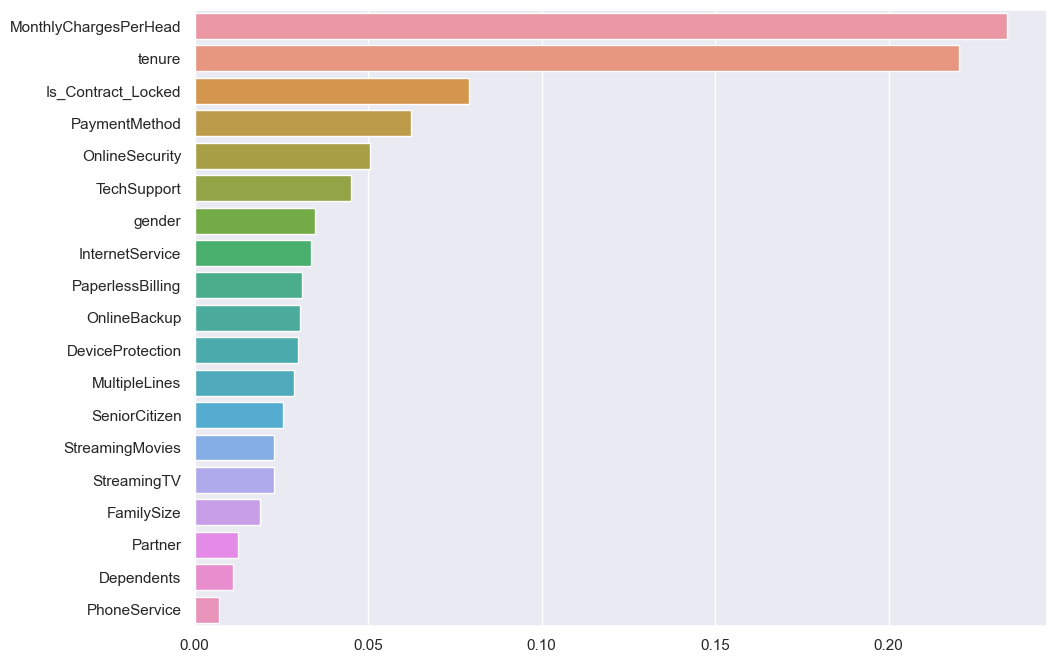

In [31]:
# feature importance
rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending= False)
rf_importance

# plot it
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x = rf_importance.values,
            y = rf_importance.index)

In [32]:
# import eli5
# eli5 package doesn't work, probably because packages are no longer compatible with sklearn

In [33]:
# outstanding 
# Try shap